In [3]:
%matplotlib inline

# Plot EEG of a selected channel 
import MNE library.

In [65]:
from scipy.io import loadmat
import numpy as np
import mne
import os
import matplotlib.pyplot as plt
import scipy.io as io

Load data into a MNE object 

Creating RawArray with float64 data, n_channels=60, n_times=481663
    Range : 0 ... 481662 =      0.000 ...   332.181 secs
Ready.


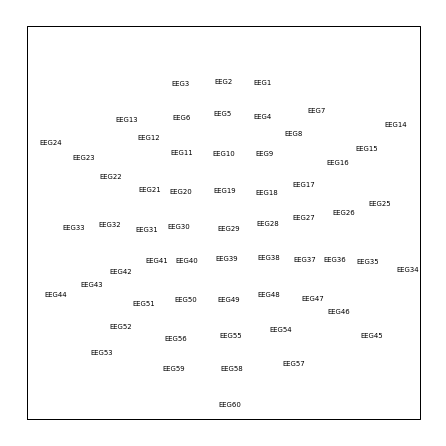

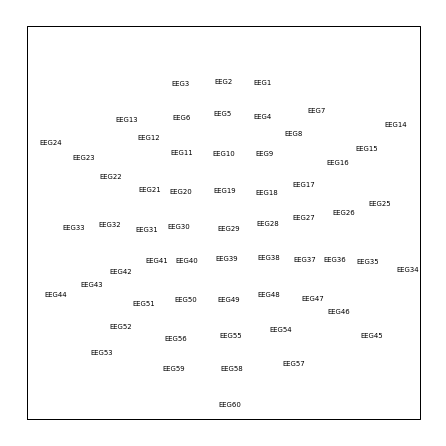

In [66]:
# specify the input data name and read mat file
fp = os.path.join('data', 'H0534K(2).mat')
data = loadmat(fp)

#
ch_names = np.concatenate(data['chlocs']['labels'][0]).tolist()
fsample = data['srate'].item(0)
Ntrial = data['EEG'].shape[0]
time_axis = np.arange(0, Ntrial, 1) / fsample
data_eeg = np.transpose(data['EEG'])
info = mne.create_info(ch_names=ch_names, sfreq=fsample, ch_types='eeg')

#
elec = data['channel_position']
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, elec)),
                                        coord_frame='head')
#
raw = mne.io.RawArray(data_eeg, info)
raw.set_montage(montage)

#
layout_from_raw = mne.channels.make_eeg_layout(raw.info)
layout_from_raw.plot()

Select the most central channel (Channel 29) for preliminary analysis

(array([[-25.86404211, -32.04394598, -32.57801175, ..., -28.07660029,
        -17.39528496, -24.9485008 ]]), array([0.00000000e+00, 6.89655172e-04, 1.37931034e-03, ...,
       3.32179310e+02, 3.32180000e+02, 3.32180690e+02]))


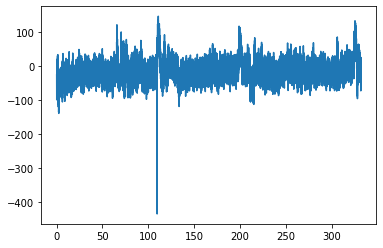

In [67]:
sampling_freq = fsample
start_stop_seconds = np.array([0, 1012])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 29-1
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
plt.plot(x, y)

Plot PSD of the selected channel 


Effective window size : 1.412 (s)


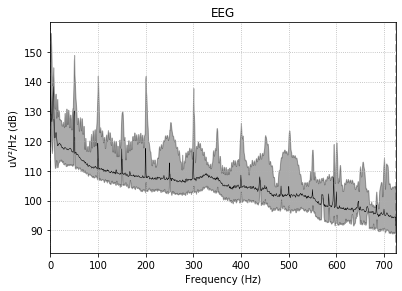

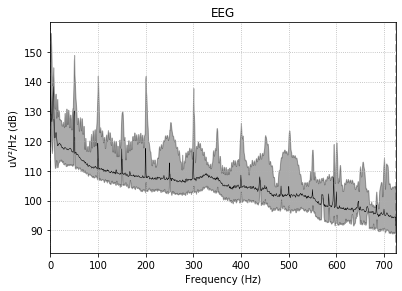

In [68]:
tmin, tmax = 0, 1012  # use the first 1012s of data
raw.plot_psd(area_mode='range', tmax=tmax, show=False, average=True)

### Noise Filtering 
A band-pass filter 0.5 ~ 60 Hz. 
Remove line noises (50 Hz)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 9571 samples (6.601 sec)

Effective window size : 1.412 (s)


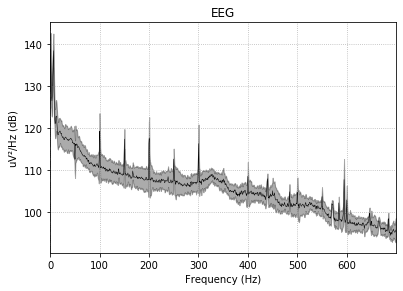

In [69]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                       stim=False, exclude='bads')
freqs = 50
raw_notch = raw.copy().notch_filter(freqs=freqs, picks=picks)

fig = raw_notch.plot_psd(fmax=700, average=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 9571 samples (6.601 sec)

Effective window size : 1.412 (s)


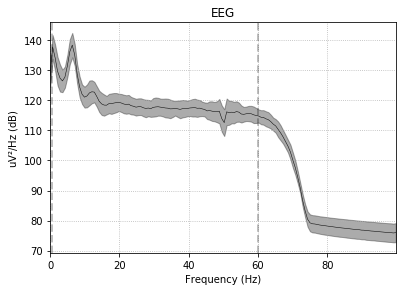

In [70]:
raw_cleaned = raw_notch.copy().filter(l_freq=0.5, h_freq=60)
fig = raw_cleaned.plot_psd(fmax=100, average=True)

### Save a matlab mat
First select the channel again

(array([[ 7.10542736e-15, -3.96444337e+00, -7.81283404e+00, ...,
        -6.18597984e-01, -3.18250842e-01,  6.21724894e-15]]), array([0.00000000e+00, 6.89655172e-04, 1.37931034e-03, ...,
       3.32179310e+02, 3.32180000e+02, 3.32180690e+02]))


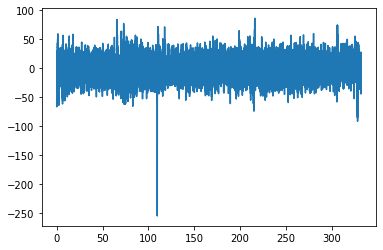

In [71]:
sampling_freq = fsample
start_stop_seconds = np.array([0, 1012])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 29-1
raw_selection = raw_cleaned[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
plt.plot(x, y)

In [72]:
a = {}
a['t'] = raw_selection[1]
a['eeg_29'] = raw_selection[0]
io.savemat('H0534K(2)_chan29.mat',a)